# Plot ESMFold Metrics

In [8]:
# basic
import os
import re
import sys
import numpy as np
import pandas as pd
import os.path as osp
import json 
from pathlib import Path
from pprint import pprint
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Mapping, Set
# torch tools
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch_scatter as ts
from torch import Tensor
# other 
from biopandas.pdb import PandasPdb
# metrics 
from sklearn.metrics import (
    matthews_corrcoef, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score)

# Metrics 

We investigate the performance of ESMFold on all 1723 samples in WALLE1.0

In [9]:
BASE=Path("/workspaces/Antibody-specific-epitope-prediction-2.0/experiments/esmfold")
METRICS=BASE/'metrics'

In [10]:
# get top-1 prediction from each json 
json_fps = [str(f) for f in METRICS.glob('*.json')]

In [11]:
def get_metric(json_fp: str) -> Tuple[str, str, float]:
    with open(json_fp, 'r') as f:
        data = json.load(f)
    d = {'abdbid': data['abdbid'],
         'mcc': data['mcc'],
         'aucroc': data['aucroc'],
         'precision': data['precision'],
         'recall': data['recall'],
         'f1': data['f1']}
    return d

In [12]:
all = {'abdbid': [], 'mcc': [], 'aucroc': [], 'precision': [], 'recall': [], 'f1': []}

for fp in json_fps:
    for k, v in get_metric(fp).items():
        all[k].append(v)

In [13]:
len(all['abdbid'])

1723

## Plot

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Set2")

/tmp/ipykernel_25857/2638466137.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


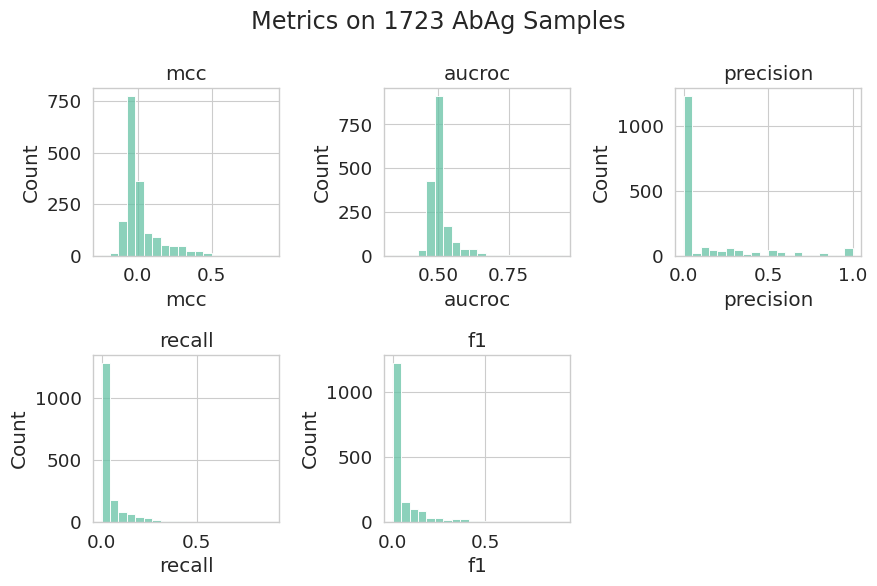

In [15]:
# plot metrics as histogram 
fig, ax = plt.subplots(2, 3, figsize=(9, 6))#, sharex=True, sharey=True)
# create bin between -1 and 1 using np 
# sns.histplot(data=all, x="mcc", bins=np.linspace(-1, 1, 21), ax=ax)
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.histplot(data=all, x=k, bins=20, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# set super title 
fig.suptitle("Metrics on 1723 AbAg Samples")
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-hist.pdf', dpi=300)

/tmp/ipykernel_25857/2512248264.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


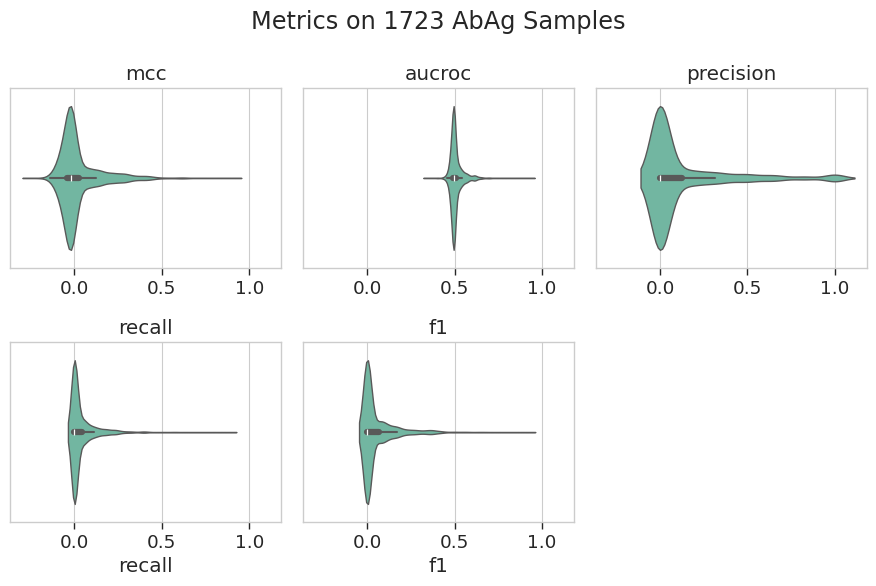

In [16]:
# violin plot 
fig, ax = plt.subplots(2, 3, figsize=(9, 6), sharex=True)
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.violinplot(data=all, x=k, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # show xticks 
    ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# set super title 
fig.suptitle("Metrics on 1723 AbAg Samples")
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-violine.pdf', dpi=300)

## Test set performance 

In [17]:
# torch tools
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch_scatter as ts
from torch import Tensor

In [19]:
split_idx = torch.load("/workspaces/Antibody-specific-epitope-prediction-2.0/data/asepv1/split/split_dict.pt")
with open("/workspaces/Antibody-specific-epitope-prediction-2.0/data/asepv1/raw/asepv1-graphs.txt") as f:
    asepv1_abdbids = [line.strip() for line in f.readlines()]

In [20]:
abdbids = all['abdbid']
test_set_abdbids  = np.array(asepv1_abdbids)[split_idx['test'].tolist()]
val_set_abdbids   = np.array(asepv1_abdbids)[split_idx['valid'].tolist()]
train_set_abdbids = np.array(asepv1_abdbids)[split_idx['train'].tolist()]
abdbid2set = {}
for abdbid in abdbids:
    if abdbid in test_set_abdbids:
        abdbid2set[abdbid] = 'test'
    elif abdbid in val_set_abdbids:
        abdbid2set[abdbid] = 'val'
    elif abdbid in train_set_abdbids:
        abdbid2set[abdbid] = 'train'
    else:
        raise ValueError(f"abdbid {abdbid} not found in any set")

In [21]:
# derive metrics from all using abdbids 
all_df = pd.DataFrame(all)
all_df['set'] = all_df['abdbid'].map(abdbid2set)

In [22]:
test_set_metric_df = all_df[all_df['set'] == 'test']

/tmp/ipykernel_25857/2708053539.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


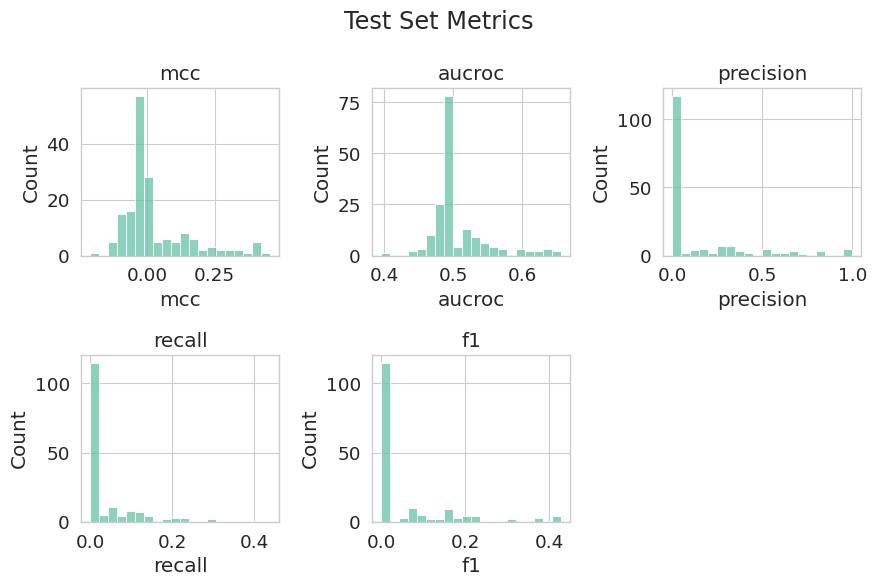

In [23]:
# plot metricsplots/ as histogram
fig, ax = plt.subplots(2, 3, figsize=(9, 6))#, sharex=True, sharey=True)
# create bin between -1 and 1 using np
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.histplot(data=test_set_metric_df, x=k, bins=20, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# remove the last plot
ax[1][2].remove()
# set super title 
fig.suptitle("Test Set Metrics")
# other settings 
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-hist-testset.pdf', dpi=300)

/tmp/ipykernel_25857/3291014362.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


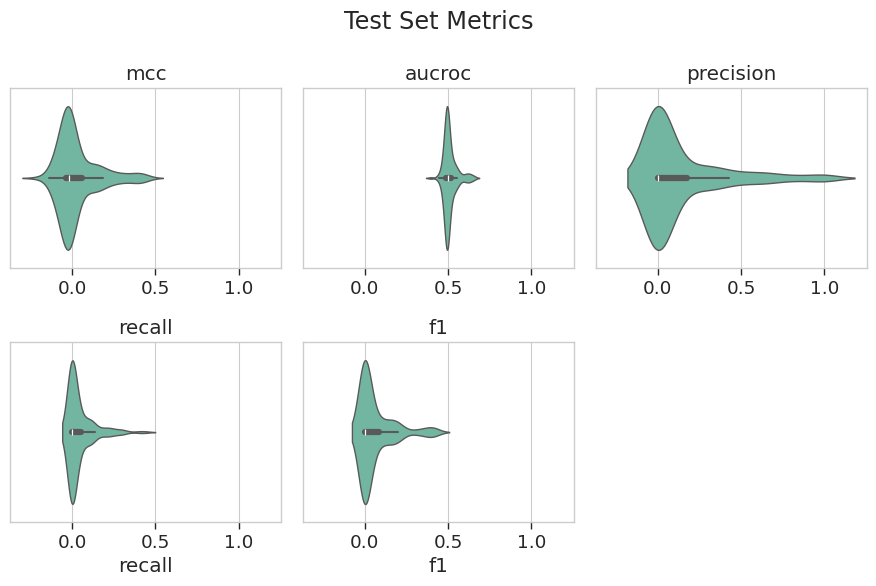

In [24]:
# violin plot
fig, ax = plt.subplots(2, 3, figsize=(9, 6), sharex=True)
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.violinplot(data=test_set_metric_df, x=k, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # show xticks
    ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# set super title 
fig.suptitle("Test Set Metrics")
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-violine-testset.pdf', dpi=300)

In [25]:
test_set_metric_df.describe()

,mcc,aucroc,precision,recall,f1
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,0.027680,0.507820,0.137034,0.043267,0.059800
std,0.125267,0.040265,0.253466,0.082489,0.108378
min,-0.208791,0.395604,0.000000,0.000000,0.000000
25%,-0.038327,0.487692,0.000000,0.000000,0.000000
50%,-0.016497,0.497011,0.000000,0.000000,0.000000
75%,0.062462,0.517057,0.178030,0.055556,0.083333
max,0.455383,0.657500,1.000000,0.440000,0.428571


In [26]:
test_set_metric_df.shape

(170, 7)